# CNN LSTM

This is the third model type of Jason Brownlee's book on LSTMs. CNNs were made to recognize and deal with pictures, so we can combine their feature extraction capabilities with the timecourse understanding of an LSTM to generate novel functionalities!!!

Appropriate archetypes of problems to throw this network at are
* Problems that have a 2D structure (Images) or 1D complex structure such as sentences, paragraphs, or a full document.

* Problems that also have order to the input. Order of images such as a video, or words in a text. Also if the output we want has a temporal structure like coherent words.


### Arcitecture
CNN --> LSTM --> Dense output


In [1]:
# Neural net stuff
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import activations

# number manip
import numpy as np
import pandas as pd
import math
import random as rand

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# I also want to hide stinky warning boxes, and 
# this: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
# had some solutions.
def hide_warnings():
    from IPython.display import HTML
    HTML('''<script>
    var code_show_err = false; 
    var code_toggle_err = function() {
     var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
     var stderr = Array.from(stderrNodes)
     if (code_show_err){
         stderr.forEach(ele => ele.style.display = 'block');
     } else {
         stderr.forEach(ele => ele.style.display = 'none');
     }
     code_show_err = !code_show_err
    } 
    document.addEventListener('DOMContentLoaded', code_toggle_err);
    </script>
    To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')
    
hide_warnings()
###########################################################
print(f"Tensor Flow Version: {tf.__version__}")


2022-01-30 21:31:19.353215: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-30 21:31:19.353255: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensor Flow Version: 2.4.0


# CNN Model Structure

In [2]:
cnn = Sequential()
cnn.add(Conv2D(1, (2,2), activation = 'relu', padding = 'same', input_shape=(10,10,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Flatten())

2022-01-30 21:31:23.306154: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-30 21:31:23.308022: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-30 21:31:23.308033: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-30 21:31:23.308048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-UJ90D1J): /proc/driver/nvidia/version does not exist
2022-01-30 21:31:23.308695: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


One issue is that CNN model only outputs one "timestep"! We can achieve this by using the good ol' ```TimeDistributed``` layer. This actually acts as the bridge stiching the CNN (or any other non-LSTM type model) to the LSTM input.

### Model definition
It can be made in two ways
1. First way
```
# define CNN model
cnn = Sequential()
cnn.add(Conv2D(...))
cnn.add(MaxPooling2D(...))
cnn.add(Flatten())
# define CNN LSTM model
model = Sequential()
model.add(TimeDistributed(cnn, ...))
model.add(LSTM(..))
model.add(Dense(...))
```
2. Second way
```
model = Sequential()
model.add(TimeDistributed(Conv2D(...))
model.add(TimeDistributed(MaxPooling2D(...)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(...))
model.add(Dense(...))
```

I personally like the first way, although the book seems to enjoy the second method.

# Moving Square Problem
A classification problem of a sequence of pixels moving either left, or right across the screen. The neural net should be able to say "left or right".

This can be made is several steps:
* Generate a square box (dim, dim)
* Initialize a pixel as start, along one of the columns 50/50
* Next step depends on previous step. Choose column over that is within the bounds of the box. (this feels recursive)

### Book architecture
The book chose to build this in two functions. The first one asks the user for the size of the square, and then initializes the starting frame. It then proceeds to call the next function which builds the "next_frame". The output of these two functions is a single "film".

#### Structure
Break problem into initialization and production. Wrap
the production inside of initialization. Have users 
interact only with initialization side of things.

In [3]:
def build_frames(size):
    pass

# I wanna make this fella recursive :)))
def next_frame(last_step, last_frame, column):
    # Prevents going out of bounds on the top
    next_step_lower = max(0, last_step-1)
    # Prevents going out of bounds on the bottom
    next_step_upper = min(last_frame.shape[0]-1, last_step+1)
    # Tells us what the next, legal, y-axis is
    next_step = rand.randint(next_step_lower, next_step_upper)
    # Sets the correct pixel to 1
    next_frame = last_frame.copy()
    next_frame[next_step, column] = 1
    
    return next_frame, next_step

def build_frames(size):
    frames = list()
    frame = np.zeros((size, size))
    step = rand.randint(0,size-1) # y-axis start
    
    right = 1 if rand.random() > 0.5 else 0
    column = size-1 if right else 0 # X-axis start
    frame[step, column] = 1
    frames.append(frame)
    
    
    for i in range(1,size):
        column = size-i-1 if right else i
        frame, step = next_frame(step, frame, column)
        frames.append(frame)
    
    return frames, right

frames, right = build_frames(2)
print(right)
frames

0


[array([[1., 0.],
        [0., 0.]]),
 array([[1., 0.],
        [0., 1.]])]

# Moving square visualization

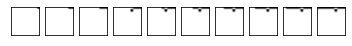

1


In [15]:
# generate sequence of frames
size = 10
frames, right = build_frames(size)
# plot all feames
plt.figure()
for i in range(size):
# create a grayscale subplot for each frame
    plt.subplot(1, size, i+1)
    plt.imshow(frames[i], cmap= "Greys" )
    # turn of the scale to make it cleaer
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# show the plot
plt.show()
print(right)

def viz_moving_box(seq):
    size = seq.shape[0]
    plt.figure()
    for i in range(size):
    # create a grayscale subplot for each frame
        plt.subplot(1, size, i+1)
        plt.imshow(seq[i], cmap= "Greys" )
        # turn of the scale to make it cleaer
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    # show the plot
    plt.show() 

# Reshaping for input to CNN
Quite a bit goes into this. Normally it would be re-shaped to ```[width, height, channels]``` but in our case we need ```[samples,timesteps,width,height,channels]```.

In [5]:
def generate_examples(size, n_patterns):
    X,y = list(), list()
    for _ in range(n_patterns):
        frames,right = build_frames(size)
        X.append(frames)
        y.append(right)
    X = np.array(X).reshape(n_patterns, size, size, size, 1)
    y = np.array(y).reshape(n_patterns, 1)
    return X,y

In [6]:
size = 5
n_patterns = 10
X,y = generate_examples(5, 10)

In [7]:
X = X.reshape(n_patterns*size,size,size,1)

Apparently this is a binary classifiation problem, right or left. This book uses the **sigmoid activation function** and the **binary_crossentropy** loss function. 

The Conv2D input layer acts as feature extraction, and there is some weird pooling layer happeining that I have never heard of.

# Defintion of the model

In [363]:
size=10

# CNN feature extraction
model = Sequential()
model.add(TimeDistributed(Conv2D(2,(2,2), activation='relu'), input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Flatten()))

# LSTM
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#print(model.summary())
X,y = generate_examples(size, 150)
model.fit(X,y,batch_size=2, epochs=1)

75/75 [==============================] - 1s 3ms/step - loss: 0.6174 - acc: 0.7047


In [355]:
X,y = generate_examples(size, 150)
model.fit(X,y,batch_size=5, epochs=1)

30/30 [==============================] - 1s 4ms/step - loss: 0.6751 - acc: 0.5738


# Evaluation and Visualization


In [364]:
X_eval,y_eval = generate_examples(size,10000)
loss, acc = model.evaluate(X_eval, y_eval, verbose=0)
print(f'Loss: {loss}, acc: {acc}')

Loss: 0.09634286910295486, acc: 0.9857000112533569


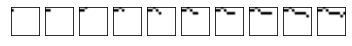

Actual: 0
Predicted: 0.10113298892974854


In [374]:
X_viz, y_viz = generate_examples(size,1)
y_hat = model.predict(X_viz)
viz_moving_box(X_viz.reshape(size,size,size))
print(f'Actual: {y_viz.reshape(1)[0]}\nPredicted: {y_hat.reshape(1)[0]}')

---
It is very interesting to me that when I have reduced training examples to only 300 from recommended 50000, I am indeed getting shittier loss and accuracy for training, yet upon evaluation I am getting some stellar resultes! What the heck is happening!

I got down to 200 training examples, and truly my loss is doing very poorly ```Loss: 0.4867803454399109```, and yet my accuracy is still very high!  ```acc: 0.9206500053405762```. This is on 100,000 evaluation generated examples, so this isn't a fluke! I would be fairly impressed with this model tbh.

Why does it do so well on the eval!!! It does spectacularly!!!

In [375]:
#model.save(f'./Accidently_made_very_good_CNN_LSTM_150-training-examples_loss-0.08_acc-0.98')